# Administrative

## Next meeting will be on 15/01/2021

# Optimizers
Why is it a bad idea to initialize everything with the same value?
<img src="opt-0.png">
<img src="opt-1.png">
<img src="opt-2.png">
<img src="opt-3.png">
<img src="opt-4.png">
<img src="opt-5.png">
<img src="opt-6.png">

# Autoencoders
Auto encoders are one of the unsupervised deep learning models. The aim of an auto encoder is dimensionality reduction and feature discovery. An auto encoder is trained to predict its own input, but to prevent the model from learning the identity mapping, some constraints are applied to the hidden units.

The simplest form of an auto encoder is a feedforward neural network where the input x is fed to the hidden layer of h(x) and h(x) is then fed to calculate the output xˆ. A simple auto encoder is shown in 
<img src="ae.png">

The following equation can describe an autoencoder:
$$\hat{x} = O(a(h) ) = Sigmoid ( c + w^{*} h(x)),$$
$$h(x) = g(a(x)) = Sigmoid (b + Wx),$$

where a is a linear transformation and both O,g are activation functions.

The autoencoder tries to reconstruct the input. So if inputs are real values, the loss function can be computed as the following mean square error (MSE):
$$l =  \frac{1}{2} \sum_{k=1}^N (x_{k} - \hat{x_{k}})^2,$$

where N is the number of examples. But if the inputs are binary, we can define our loss function as a binary cross entropy between each pixel of the target (which is the input itself) and the output. In this case the output can be considered as a probability:

$$l =  - \sum_{k=1}^N \big\{x_{k} log (\hat{x_{k}}) + (1 - x_{k}) log(1 - \hat{x_{k}})\big\}$$

It can be shown that if a single layer linear autoencoder with no activation function is used, the subspace spanned by AE's weights is the same as PCA's subspace.

# Denoising Auto Encoders (DAE)
In a denoising auto encoder the goal is to create a more robust model to noise. The motivation is that the hidden layer should be able to capture high level representations and be robust to small changes in the input. The input of a DAE is noisy data but the target is the original data without noise:

$$\hat{\tilde{x}} = O(a(h) ) = Sigmoid ( c + w^{*} h(\tilde{x})),$$
$$h(\tilde{x}) = g(a(\tilde{x})) = Sigmoid (b + W\tilde{x}),$$
$$l = \frac{1}{2} \sum_{k=1}^N (x_{k} - \hat{\tilde{x_{k}}})^2$$
$$l =  - \sum_{k=1}^N \big\{x_{k} log (\hat{\tilde{x}}_{k}) + (1 - x_{k}) log(1 - \hat{\tilde{x_{k}}})\big\}$$

Where x˜ is the noisy input. DAE can be used to denoise the input.

<img src="dae-0.png">
<img src="dae-1.png">
<img src="dae-2.png">
<img src="dae-3.png">

In [1]:
import os

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

if not os.path.exists('./mlp_img'):
    os.mkdir('./mlp_img')
    
if not os.path.exists('./filters'):
    os.mkdir('./filters')

def to_img(x):
    x = x.view(x.size(0), 1, 28, 28)
    return x

num_epochs = 20
batch_size = 128
learning_rate = 1e-3


def add_noise(img):
    noise = torch.randn(img.size()) * 0.2
    noisy_img = img + noise
    return noisy_img


def plot_sample_img(img, name):
    img = img.view(1, 28, 28)
    save_image(img, './sample_{}.png'.format(name))


def min_max_normalization(tensor, min_value, max_value):
    min_tensor = tensor.min()
    tensor = (tensor - min_tensor)
    max_tensor = tensor.max()
    tensor = tensor / max_tensor
    tensor = tensor * (max_value - min_value) + min_value
    return tensor


def tensor_round(tensor):
    return torch.round(tensor)


img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda tensor:min_max_normalization(tensor, 0, 1)),
    transforms.Lambda(lambda tensor:tensor_round(tensor))
])

dataset = MNIST('./data', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(True),
            nn.Linear(256, 64),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(True),
            nn.Linear(256, 28 * 28),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


model = autoencoder()
if torch.cuda.is_available():
    model=model.cuda()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=1e-5)

for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = img.view(img.size(0), -1)
        noisy_img = add_noise(img)
        
        if torch.cuda.is_available():
            img = img.cuda()
            noisy_img = noisy_img.cuda()
        # ===================forward=====================
        output = model(noisy_img)
        loss = criterion(output, img)
        MSE_loss = nn.MSELoss()(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}, MSE_loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.item(), MSE_loss.item()))
    if epoch % 10 == 0:
        x = to_img(img.cpu().data)
        x_hat = to_img(output.cpu())
        x_noisy = to_img(noisy_img.cpu())
        weights = to_img(model.encoder[0].weight.cpu())
        save_image(x, './mlp_img/x_{}.png'.format(epoch))
        save_image(x_hat, './mlp_img/x_hat_{}.png'.format(epoch))
        save_image(x_noisy, './mlp_img/x_noisy_{}.png'.format(epoch))
        save_image(weights, './filters/epoch_{}.png'.format(epoch))

torch.save(model.state_dict(), './sim_autoencoder.pth')

epoch [1/20], loss:0.1220, MSE_loss:0.0379
epoch [2/20], loss:0.0936, MSE_loss:0.0287
epoch [3/20], loss:0.0807, MSE_loss:0.0244
epoch [4/20], loss:0.0734, MSE_loss:0.0220
epoch [5/20], loss:0.0664, MSE_loss:0.0198
epoch [6/20], loss:0.0623, MSE_loss:0.0187
epoch [7/20], loss:0.0598, MSE_loss:0.0177
epoch [8/20], loss:0.0584, MSE_loss:0.0175
epoch [9/20], loss:0.0577, MSE_loss:0.0171
epoch [10/20], loss:0.0563, MSE_loss:0.0169
epoch [11/20], loss:0.0547, MSE_loss:0.0162
epoch [12/20], loss:0.0523, MSE_loss:0.0153
epoch [13/20], loss:0.0551, MSE_loss:0.0164
epoch [14/20], loss:0.0518, MSE_loss:0.0154
epoch [15/20], loss:0.0526, MSE_loss:0.0156
epoch [16/20], loss:0.0513, MSE_loss:0.0153
epoch [17/20], loss:0.0516, MSE_loss:0.0154
epoch [18/20], loss:0.0527, MSE_loss:0.0155
epoch [19/20], loss:0.0494, MSE_loss:0.0147
epoch [20/20], loss:0.0496, MSE_loss:0.0149


In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

--------------------------./mlp_img-------------------------
x_noisy_0.png


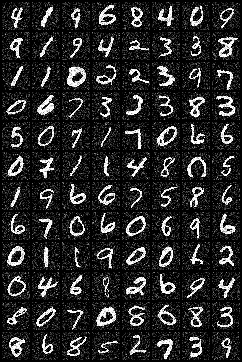

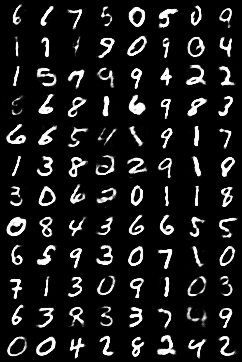

x_hat_10.png
x_0.png


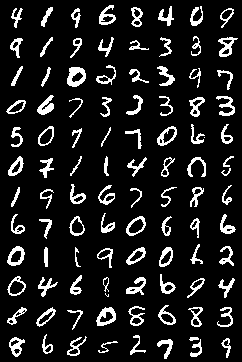

x_noisy_10.png


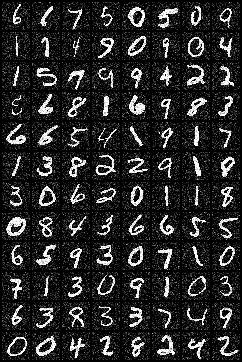

x_hat_0.png


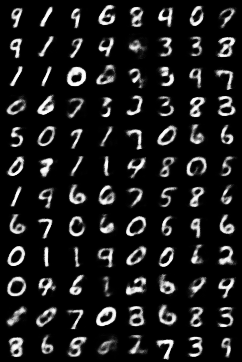

x_10.png


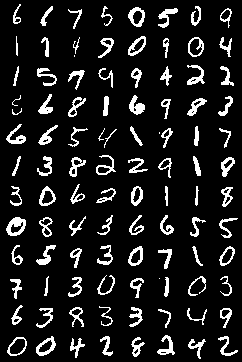

--------------------------./filters-------------------------
epoch_0.png


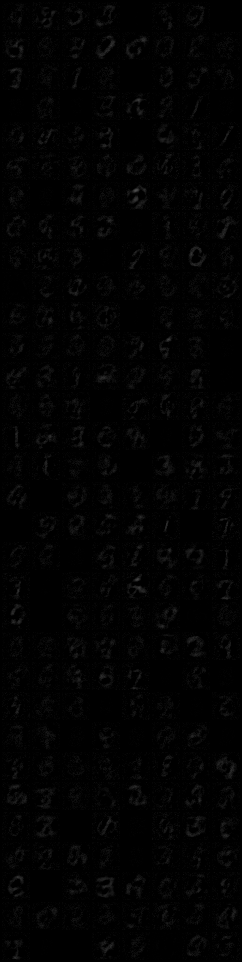

epoch_10.png


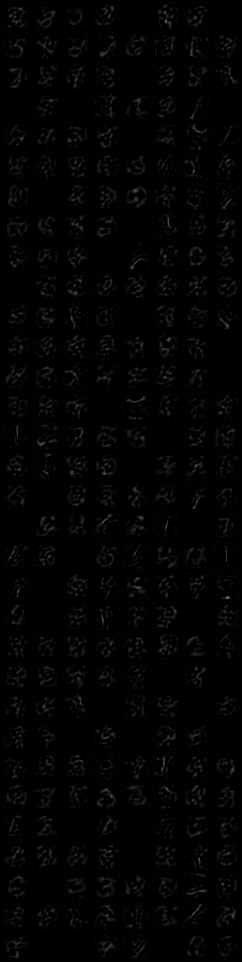

In [3]:
from PIL import Image
import os, os.path
import IPython

imgs = []
paths = ["./mlp_img","./filters"]
for path in paths:
    print("--------------------------"+path+"-------------------------")
    valid_images = [".png"]
    for f in os.listdir(path):
        ext = os.path.splitext(f)[1]
        if ext.lower() not in valid_images:
            continue
        print(f)
        display(IPython.display.Image(os.path.join(path,f),width=900
                                     ))

# Variational AutoEncoder
A good video on VAE: https://www.youtube.com/watch?v=9zKuYvjFFS8
<img src="VAE.png">
<img src="VAE1.png">
<img src="VAE2.png">
<img src="VAE3.png">
<img src="VAE4.png">
<img src="VAE5.png">
<img src="VAE6.png">

In [4]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [5]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()

In [6]:
vae

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [7]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [8]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        if torch.cuda.is_available():
            data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [9]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            if torch.cuda.is_available():
                data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [10]:
for epoch in range(1, 51):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 546.124844


/Users/hafez/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [10000/60000 (17%)]	Loss: 189.163105
Train Epoch: 1 [20000/60000 (33%)]	Loss: 176.606348
Train Epoch: 1 [30000/60000 (50%)]	Loss: 155.278389
Train Epoch: 1 [40000/60000 (67%)]	Loss: 161.528760
Train Epoch: 1 [50000/60000 (83%)]	Loss: 163.445137
====> Epoch: 1 Average loss: 178.8229
====> Test set loss: 161.5823
Train Epoch: 2 [0/60000 (0%)]	Loss: 151.763691
Train Epoch: 2 [10000/60000 (17%)]	Loss: 157.838350
Train Epoch: 2 [20000/60000 (33%)]	Loss: 152.314229
Train Epoch: 2 [30000/60000 (50%)]	Loss: 160.431611
Train Epoch: 2 [40000/60000 (67%)]	Loss: 150.222793
Train Epoch: 2 [50000/60000 (83%)]	Loss: 152.907783
====> Epoch: 2 Average loss: 157.5493
====> Test set loss: 154.9751
Train Epoch: 3 [0/60000 (0%)]	Loss: 157.850625
Train Epoch: 3 [10000/60000 (17%)]	Loss: 155.597686
Train Epoch: 3 [20000/60000 (33%)]	Loss: 153.172090
Train Epoch: 3 [30000/60000 (50%)]	Loss: 153.590762
Train Epoch: 3 [40000/60000 (67%)]	Loss: 153.392832
Train Epoch: 3 [50000/60000 (83%)]	Loss: 1

====> Epoch: 22 Average loss: 139.1701
====> Test set loss: 140.4239
Train Epoch: 23 [0/60000 (0%)]	Loss: 141.489238
Train Epoch: 23 [10000/60000 (17%)]	Loss: 139.434697
Train Epoch: 23 [20000/60000 (33%)]	Loss: 138.228994
Train Epoch: 23 [30000/60000 (50%)]	Loss: 146.131055
Train Epoch: 23 [40000/60000 (67%)]	Loss: 143.735850
Train Epoch: 23 [50000/60000 (83%)]	Loss: 132.416709
====> Epoch: 23 Average loss: 139.0308
====> Test set loss: 140.1049
Train Epoch: 24 [0/60000 (0%)]	Loss: 134.822012
Train Epoch: 24 [10000/60000 (17%)]	Loss: 132.914756
Train Epoch: 24 [20000/60000 (33%)]	Loss: 132.142979
Train Epoch: 24 [30000/60000 (50%)]	Loss: 137.027744
Train Epoch: 24 [40000/60000 (67%)]	Loss: 139.898008
Train Epoch: 24 [50000/60000 (83%)]	Loss: 136.863633
====> Epoch: 24 Average loss: 138.8655
====> Test set loss: 140.1128
Train Epoch: 25 [0/60000 (0%)]	Loss: 145.047529
Train Epoch: 25 [10000/60000 (17%)]	Loss: 141.698135
Train Epoch: 25 [20000/60000 (33%)]	Loss: 136.769531
Train Epoch: 

Train Epoch: 44 [30000/60000 (50%)]	Loss: 145.389238
Train Epoch: 44 [40000/60000 (67%)]	Loss: 138.703125
Train Epoch: 44 [50000/60000 (83%)]	Loss: 132.002012
====> Epoch: 44 Average loss: 136.2023
====> Test set loss: 138.2634
Train Epoch: 45 [0/60000 (0%)]	Loss: 135.260771
Train Epoch: 45 [10000/60000 (17%)]	Loss: 135.814160
Train Epoch: 45 [20000/60000 (33%)]	Loss: 137.954160
Train Epoch: 45 [30000/60000 (50%)]	Loss: 135.977998
Train Epoch: 45 [40000/60000 (67%)]	Loss: 138.974639
Train Epoch: 45 [50000/60000 (83%)]	Loss: 143.299092
====> Epoch: 45 Average loss: 135.9144
====> Test set loss: 138.0682
Train Epoch: 46 [0/60000 (0%)]	Loss: 135.090127
Train Epoch: 46 [10000/60000 (17%)]	Loss: 138.383350
Train Epoch: 46 [20000/60000 (33%)]	Loss: 132.927207
Train Epoch: 46 [30000/60000 (50%)]	Loss: 135.462187
Train Epoch: 46 [40000/60000 (67%)]	Loss: 137.046455
Train Epoch: 46 [50000/60000 (83%)]	Loss: 126.463496
====> Epoch: 46 Average loss: 135.6877
====> Test set loss: 137.9652
Train Ep

In [11]:
import IPython,os

with torch.no_grad():
    z = torch.randn(64, 2)
    sample = vae.decoder(z)
    
    if torch.cuda.is_available():
        z=z.cuda()
        sample=sample.cuda()
    
    save_image(sample.view(64, 1, 28, 28), './samples/sample_' + '.png')

--------------------------./samples-------------------------
sample_.png


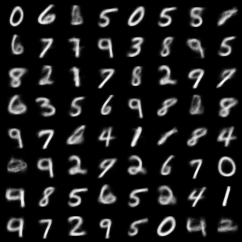

In [12]:
from PIL import Image
import os, os.path
import IPython

imgs = []
paths = ["./samples"]
for path in paths:
    print("--------------------------"+path+"-------------------------")
    valid_images = [".png"]
    for f in os.listdir(path):
        ext = os.path.splitext(f)[1]
        if ext.lower() not in valid_images:
            continue
        print(f)
        display(IPython.display.Image(os.path.join(path,f),width=900))

#  transposed convolutions
- fractionally strided convolutions
- deconvolution (Wrong!)
<img src="padding_strides_transposed.gif">
https://github.com/vdumoulin/conv_arithmetic

In [13]:

# Simple Convolutional Autoencoder

import torch
import torch.nn as nn
import torch.utils as utils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [14]:

# Set Hyperparameters

epoch = 10
batch_size =100
learning_rate = 0.0005

# Download Data

mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test  = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

# Set Data Loader(input pipeline)

train_loader = torch.utils.data.DataLoader(dataset=mnist_train,batch_size=batch_size,shuffle=True)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/Users/distiller/project/conda/conda-bld/pytorch_1587428061935/work/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [15]:
# Encoder 
# torch.nn.Conv2d(in_channels, out_channels, kernel_size,
#                 stride=1, padding=0, dilation=1,
#                 groups=1, bias=True)
# batch x 1 x 28 x 28 -> batch x 512

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,32,3,padding=1),   # batch x 16 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,32,3,padding=1),   # batch x 16 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,64,3,padding=1),  # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.Conv2d(64,64,3,padding=1),  # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2)   # batch x 64 x 14 x 14
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,128,3,padding=1),  # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.Conv2d(128,128,3,padding=1),  # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(128,256,3,padding=1),  # batch x 64 x 7 x 7
                        nn.ReLU()
        )
        
                
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size, -1)
        return out
    
encoder = Encoder()
if torch.cuda.is_available():
    encoder = encoder.cuda()

In [16]:
# Decoder 
# torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size,
#                          stride=1, padding=0, output_padding=0,
#                          groups=1, bias=True)
# output_height = (height-1)*stride + kernel_size - 2*padding + output_padding
# batch x 512 -> batch x 1 x 28 x 28

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(256,128,3,2,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,128,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,64,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.ConvTranspose2d(64,64,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(64,32,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,32,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,1,3,2,1,1),
                        nn.ReLU()
        )
        
    def forward(self,x):
        out = x.view(batch_size,256,7,7)
        out = self.layer1(out)
        out = self.layer2(out)
        return out

decoder = Decoder()
if torch.cuda.is_available():
    decoder=decoder.cuda()

In [17]:
# Check output of autoencoder

for image,label in train_loader:
    if torch.cuda.is_available():
        image = image.cuda()
    
    output = encoder(image)
    output = decoder(output)
    print(output.size())
    break

torch.Size([100, 1, 28, 28])


In [18]:
# loss func and optimizer
# we compute reconstruction after decoder so use Mean Squared Error
# In order to use multi parameters with one optimizer,
# concat parameters after changing into list

parameters = list(encoder.parameters())+ list(decoder.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

In [19]:
# train encoder and decoder
# save and load model
if not os.path.exists('./model'):
    os.mkdir('./model')
try:
    encoder, decoder = torch.load('./model/deno_autoencoder.pkl')
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass

for i in range(epoch):
    for image,label in train_loader:
        image_n = torch.mul(image+0.25, 0.1 * torch.rand(batch_size,1,28,28))
        if torch.cuda.is_available():
            image = image.cuda()
            image_n = image_n.cuda()
        #label = label.float().cuda()
        optimizer.zero_grad()
        output = encoder(image_n)
        output = decoder(output)
        loss = loss_func(output,image)
        loss.backward()
        optimizer.step()
    print('epoch [{}/{}], loss:{:.4f}'
          .format(i + 1, epoch, loss.item()))
        
                
torch.save([encoder,decoder],'./model/deno_autoencoder.pkl')
print(loss)


--------model not restored--------



/Users/hafez/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/hafez/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


epoch [1/10], loss:0.0097
epoch [2/10], loss:0.0076
epoch [3/10], loss:0.0074
epoch [4/10], loss:0.0060
epoch [5/10], loss:0.0061
epoch [6/10], loss:0.0058
epoch [7/10], loss:0.0060
epoch [8/10], loss:0.0057
epoch [9/10], loss:0.0051
epoch [10/10], loss:0.0056
tensor(0.0056, grad_fn=<MseLossBackward>)


/Users/hafez/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/hafez/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


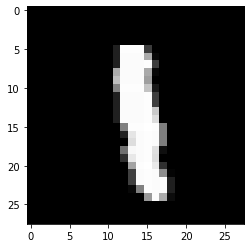

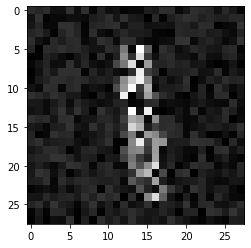

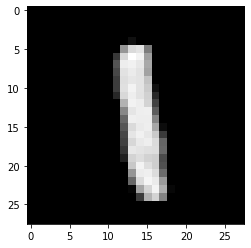

tensor(1)


In [20]:

# check image with noise and denoised image\n# Better image if you train more or upgrade the model\n
img = image[0].cpu()
input_img = image_n[0].cpu()
output_img = output[0].cpu()

origin = img.numpy()
inp = input_img.numpy()
out = output_img.detach().numpy()

plt.imshow(origin[0],cmap='gray')
plt.show()

plt.imshow(inp[0],cmap='gray')
plt.show()

plt.imshow(out[0],cmap="gray")
plt.show()

print(label[0])

# Checkerboard Artifacts
<img src="dec.png">
https://distill.pub/2016/deconv-checkerboard/

## Pixel shuffle
Rearranges elements in a tensor of shape $(*, C \times r^2, H, W)$ to a tensor of shape $(*, C, H \times r, W \times r)$.
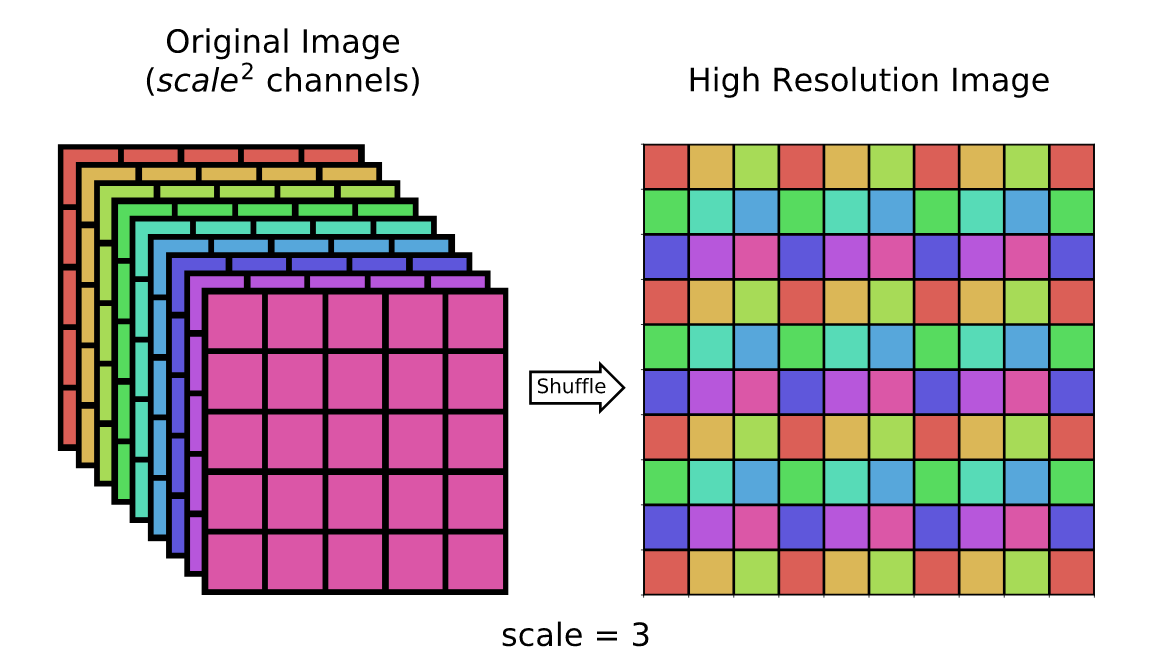

# Assignment6 (Deadline: 15/01/2021)
- Write a Variational Convolutional AutoEncoder on CFAR10 + Add denoising to the model
- Use the latent space for CFAR10 classification
- Write Adam optimizer in PyTorch (without using nn.Adam!)
- Extra point: Write a Convolutional Variational Auto Encoder and use PixelShuffle instead of TransposeConv
- Extra point: To do your previous assignment (robot classification) on latent space of a trained CAE

## Refrences:
### CS231n Standford
### PyTorch Documentation
### https://reyhaneaskari.github.io/AE.htm
### https://github.com/lyeoni/pytorch-mnist-VAE
### https://distill.pub/2016/deconv-checkerboard
### https://davideliu.com/2019/11/08/variational-autoencoder/
### https://towardsdatascience.com/reparameterization-trick-126062cfd3c3
### https://arxiv.org/pdf/1312.6114.pdf